<a href="https://colab.research.google.com/github/Weverton-Vitor/segmentation-cell-unet/blob/main/semantic_segmentation_of_cells_on_microscope_images_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Cells On Microscope Images using UNet

## 0. Imports and install packeges

In [2]:
import os
import shutil
import zipfile
import random
import json
from typing import Tuple

import numpy as np
import skimage
import tifffile

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CocoDetection
from torchvision import datasets, transforms
import torchvision
from torchvision import datasets, transforms
import pycocotools.mask as coco_mask

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches


## 1. Get the dataset

### 1.1 Donwload images

In [9]:
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip

--2024-02-11 01:57:12--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 52.219.168.85, 3.5.138.123, 52.219.47.209, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|52.219.168.85|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1241715651 (1.2G) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   1.16G  13.1MB/s    in 93s     

2024-02-11 01:58:46 (12.7 MB/s) - ‘images.zip’ saved [1241715651/1241715651]



In [10]:
dataset_path_zip = '/content/images.zip'
zipfile.ZipFile(dataset_path_zip).extractall('/content/')

In [11]:
# 5% of the train annotations
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/2_train5percent.json

# Validation and Test annotations
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json

--2024-02-11 01:59:07--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/2_train5percent.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 52.219.171.94, 3.5.135.116, 52.219.46.109, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|52.219.171.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27988522 (27M) [application/json]
Saving to: ‘2_train5percent.json’

2_train5percent.jso 100%[===================>]  26.69M  7.51MB/s    in 3.6s    

2024-02-11 01:59:11 (7.51 MB/s) - ‘2_train5percent.json’ saved [27988522/27988522]

--2024-02-11 01:59:11--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com).

### 1.2 Create custom datasets and Visualizing random images of dataset

In [96]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, root, annFile, transform=None, target_transform=None):
        self.transform = transform
        self.coco_dataset = CocoDetection(root=root, annFile=annFile, target_transform=target_transform)

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, ann = self.coco_dataset[idx]
        w, h = img.size
        mask = Image.fromarray(self.create_mask(w, h, ann).astype('uint8'))
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

    def create_mask(self, width, height, ann):
      # Create an empty mask as a numpy array
      mask_np = np.zeros((height, width), dtype=np.uint16)

      # Counter for the object number
      object_number = 1

      # Extract segmentation polygon
      for annotation in ann:
        for seg in annotation['segmentation']:
            if type(seg) is list:
              # Convert polygons to a binary mask and add it to the main mask
              rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
              mask_np[rr, cc] = object_number
              object_number += 1 #We are assigning each object a unique integer value (labeled mask)

      return mask_np

    def show_random_samples(self, qty: int=5) -> None:
      random_samples = random.sample(range(len(self.coco_dataset)), k=qty)

      fig = plt.figure(figsize=(15, 15))

      for i, sample in enumerate(random_samples):
        fig.add_subplot(1, qty, i+1)
        plt.imshow(self.coco_dataset[sample][0])
        plt.axis('off')

    def show_random_samples_with_annotations_poligons(self, fill_polygons: bool=False) -> None:
      random_samples = random.sample(range(len(self.coco_dataset)), k=4)

      # fig = plt.figure(figsize=(15, 15))
      fig, axs = plt.subplots(2, 2, figsize=(15, 15))

      for idx, ax in enumerate(axs.flat):
        # fig.add_subplot(1, qty, i+1)
        ax.imshow(self.coco_dataset[random_samples[idx]][0])
        ax.axis('off')

        annotations = self.coco_dataset[random_samples[idx]][1]
        for ann in annotations:
          for seg in ann['segmentation']:
            if type(seg) is list:
              poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
              polygon = plt.Polygon(poly, closed=True, edgecolor='g', fill=fill_polygons, facecolor='none')
              ax.add_patch(polygon)


In [97]:
# Train, Val and Test images and annotation paths
train_dataset_image_root_path = '/content/images/livecell_train_val_images'
train_dataset_annotations_root_path = '/content/2_train5percent.json'

val_dataset_image_root_path = '/content/images/livecell_train_val_images'
val_dataset_annotations_root_path = '/content/livecell_coco_val.json'

test_dataset_image_root_path = '/content/images/livecell_test_images'
test_dataset_annotations_root_path = '/content/livecell_coco_test.json'

In [98]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [99]:
# Train dataset (only 5%)
train_dataset = CocoSegmentationDataset(root=train_dataset_image_root_path, transform=transform, annFile=train_dataset_annotations_root_path);

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


In [116]:
val_dataset = CocoSegmentationDataset(root=train_dataset_image_root_path,  transform=transform, annFile=val_dataset_annotations_root_path)

loading annotations into memory...
Done (t=8.22s)
creating index...
index created!


In [101]:
np.asarray(train_dataset[0][0]).shape

(3, 224, 224)

In [102]:
train_dataset[0]

(tensor([[[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.4588, 0.5137, 0.4902],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4980, 0.4471],
          [0.5059, 0.5020, 0.5020,  ..., 0.5216, 0.5294, 0.5255]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.4588, 0.5137, 0.4902],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4980, 0.4471],
          [0.5059, 0.5020, 0.5020,  ..., 0.5216, 0.5294, 0.5255]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ...,

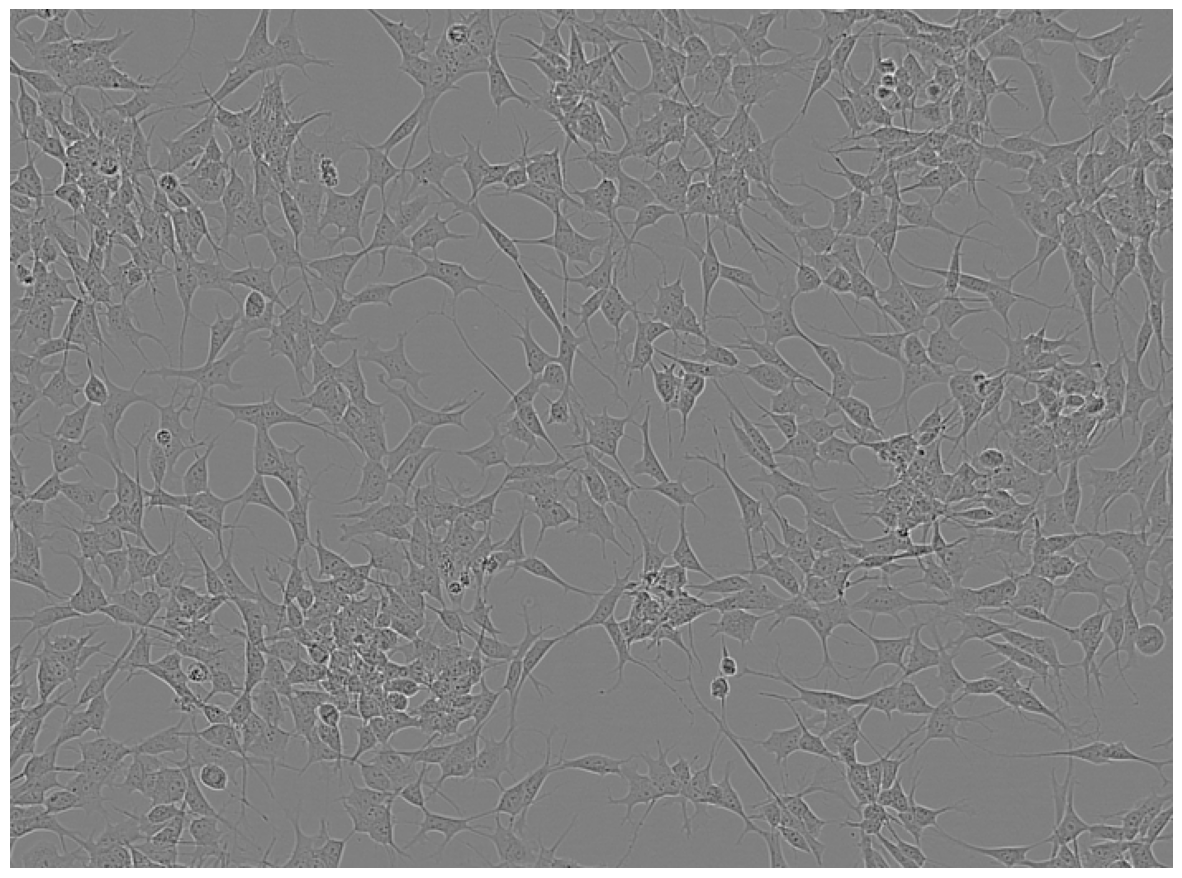

In [103]:
train_dataset.show_random_samples(qty=1)

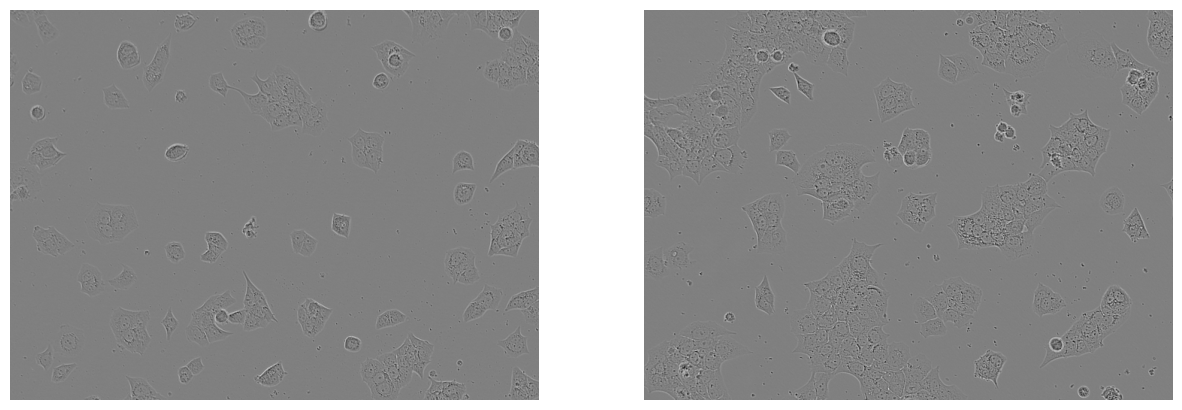

In [89]:
val_dataset.show_random_samples(qty=2)

### 1.3 Visualizing the annotations of a image


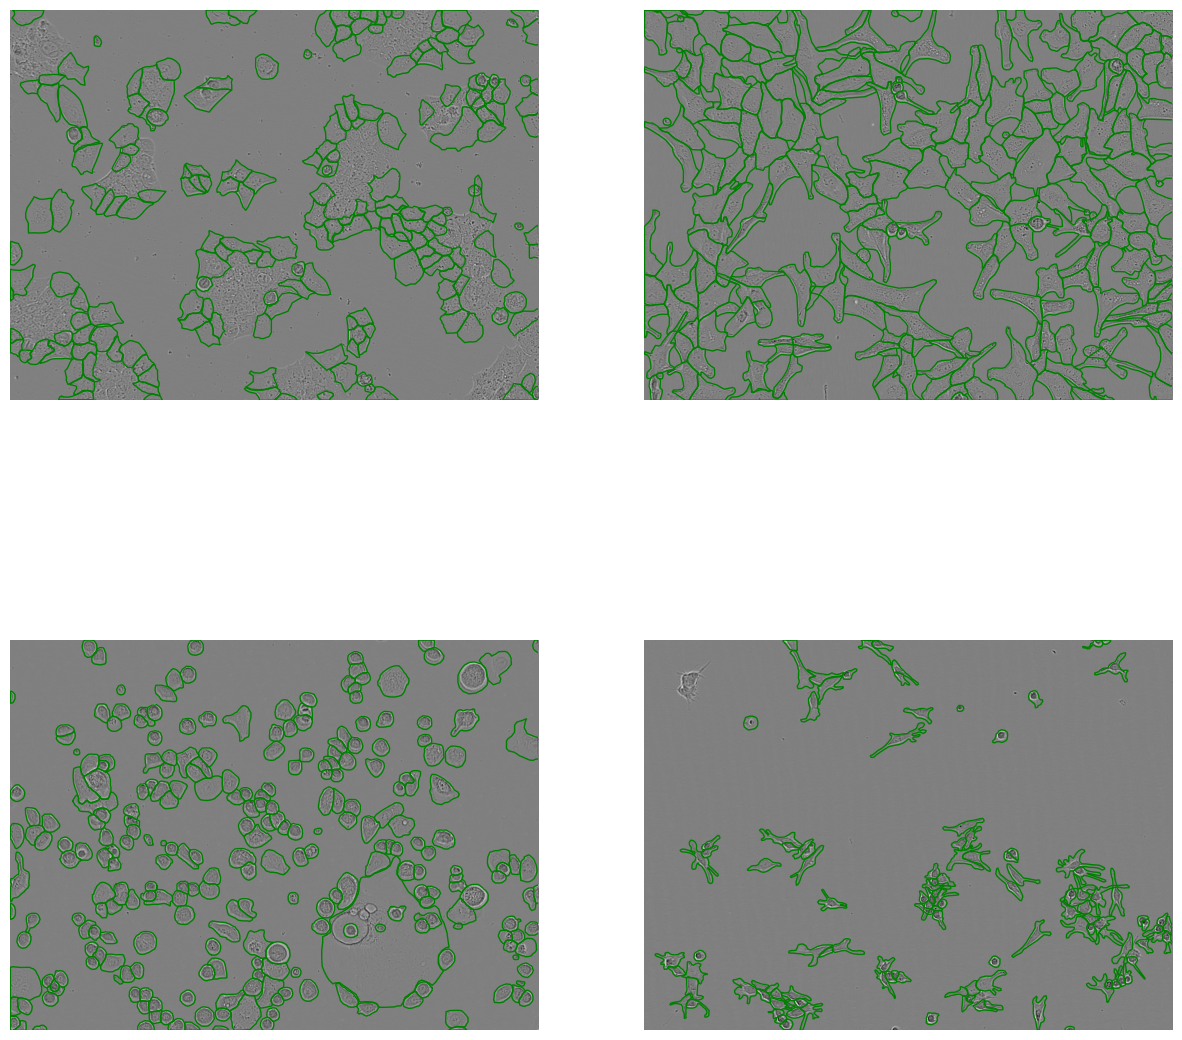

In [104]:
train_dataset.show_random_samples_with_annotations_poligons()

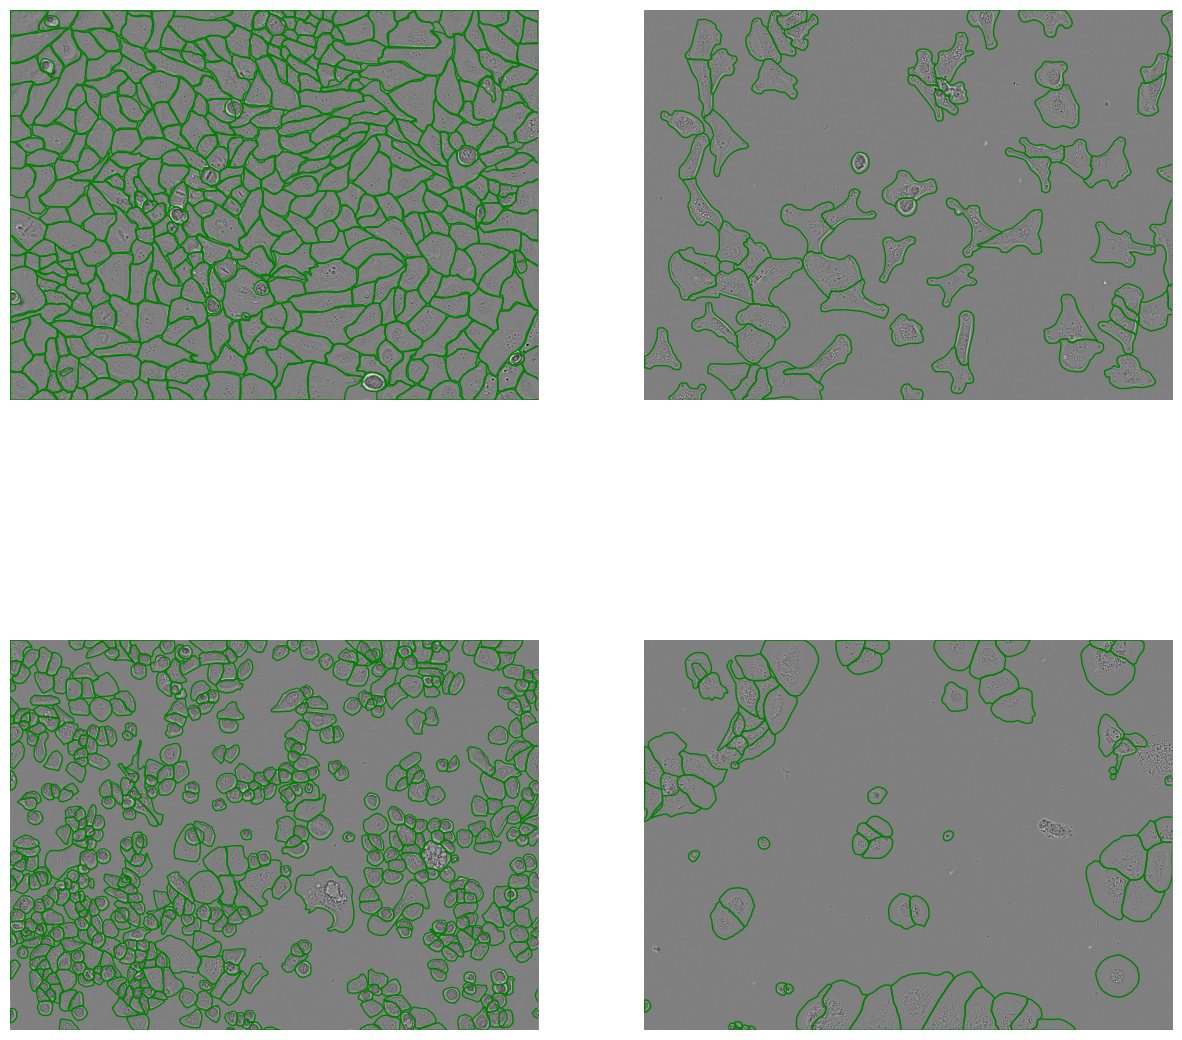

In [91]:
val_dataset.show_random_samples_with_annotations_poligons()

### 1.3 Visualizing the maks segmentation

In [105]:
train_dataset[0]

(tensor([[[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.4588, 0.5137, 0.4902],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4980, 0.4471],
          [0.5059, 0.5020, 0.5020,  ..., 0.5216, 0.5294, 0.5255]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.4588, 0.5137, 0.4902],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4980, 0.4471],
          [0.5059, 0.5020, 0.5020,  ..., 0.5216, 0.5294, 0.5255]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5059,  ...,

In [108]:
def show_random_masks(dataset: datasets.CocoDetection, qty: int=5) -> None:
  random_masks = random.sample(range(len(dataset)), k=qty)

  fig = plt.figure(figsize=(15, 15))

  for i, mask in enumerate(random_masks):
    fig.add_subplot(1, qty, i+1)
    plt.imshow(dataset[mask][1].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
  plt.show()

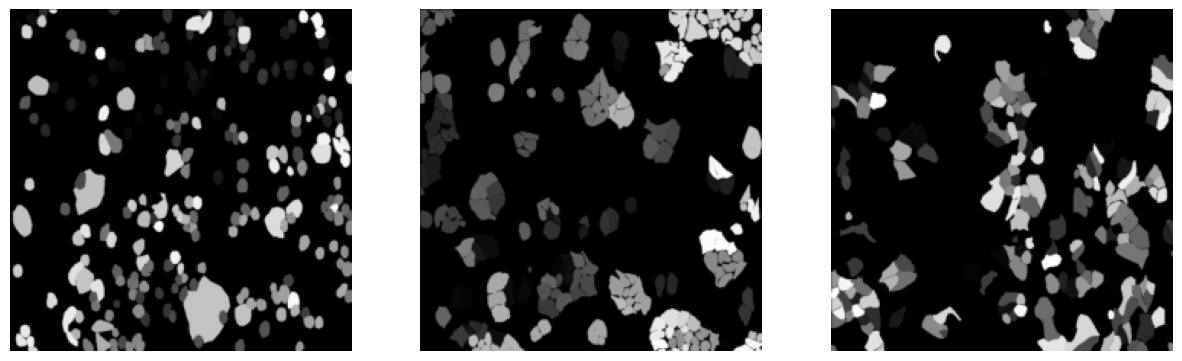

In [109]:
show_random_masks(dataset=train_dataset, qty=3)

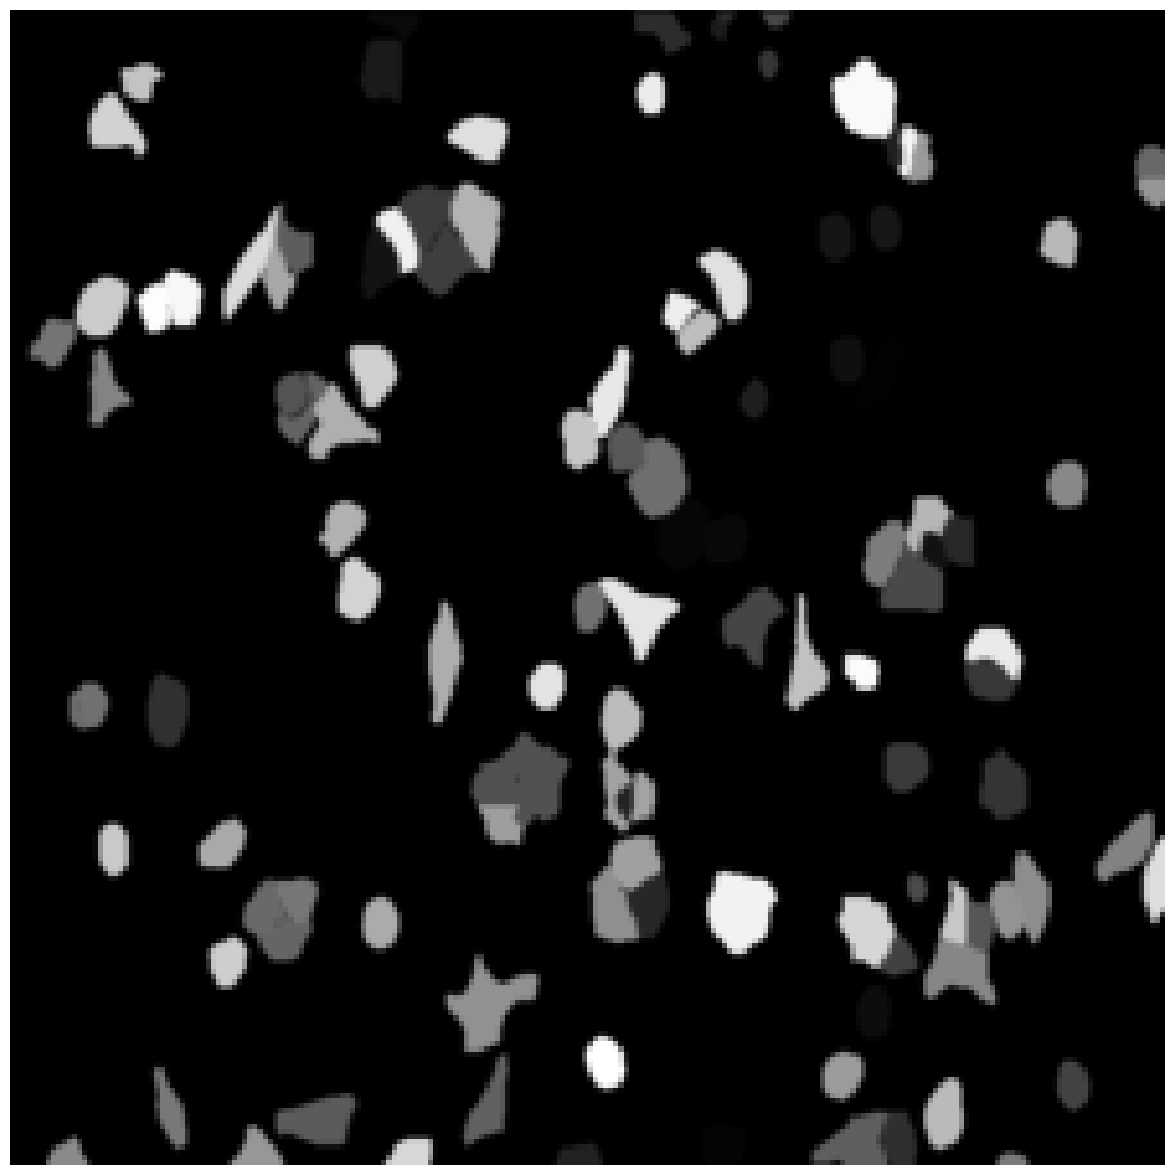

In [117]:
show_random_masks(dataset=val_dataset, qty=1)

### 1.4 Visualizing random images and its respective masks

In [111]:
def show_random_image_and_mask(dataset: datasets.CocoDetection) -> None:
  random_sample = random.choice(range(len(dataset)))

  fig = plt.figure(figsize=(15, 15))

  fig.add_subplot(1, 2, 1)
  plt.imshow(dataset[random_sample][0].permute(1, 2, 0), cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  fig.add_subplot(1, 2, 2)
  plt.imshow(dataset[random_sample][1].permute(1, 2, 0), cmap='gray')
  plt.title('Mask')

  plt.axis('off')
  plt.show()

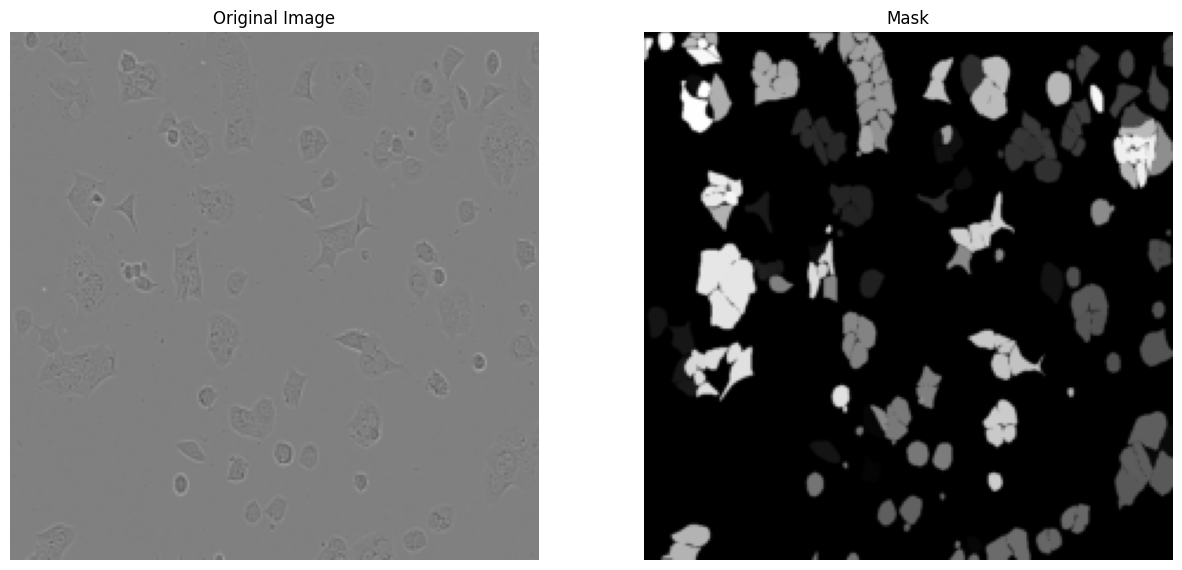

In [115]:
show_random_image_and_mask(train_dataset)

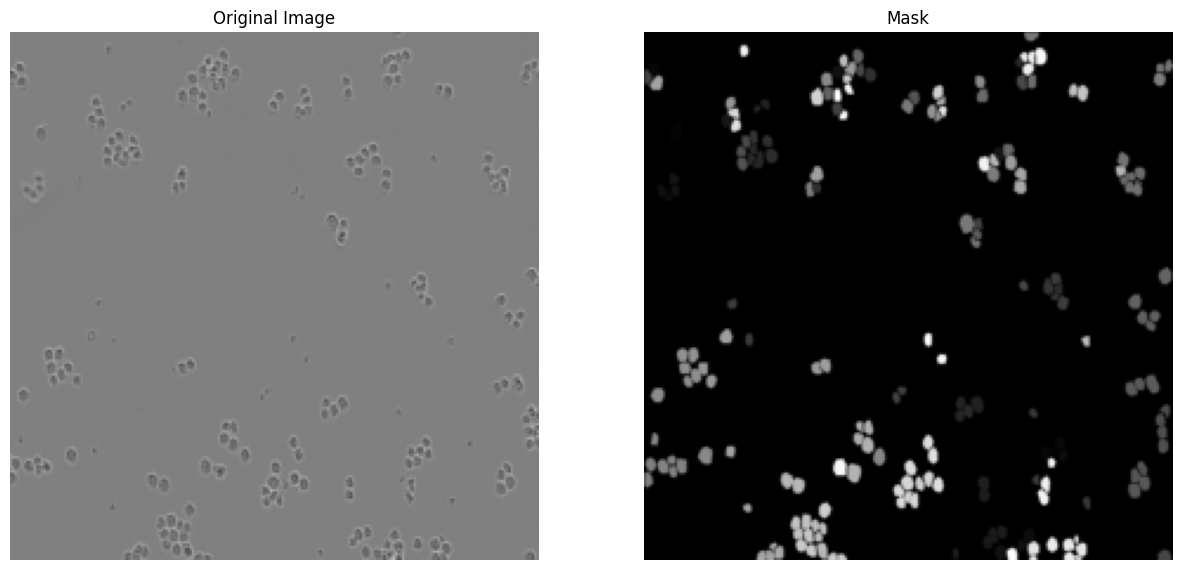

In [118]:
show_random_image_and_mask(val_dataset)

### 1.5 Generate DataLoader and tranforms images with torchvision

#### 1.5.1 Device Agnostic

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### 1.5.2 Create DataLoaders

In [121]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=32)

In [125]:
next(iter(train_dataloader))

[tensor([[[[0.5020, 0.5059, 0.5020,  ..., 0.5020, 0.5020, 0.5059],
           [0.5020, 0.5059, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
           [0.5059, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
           ...,
           [0.5098, 0.5059, 0.4980,  ..., 0.5020, 0.5020, 0.5020],
           [0.5137, 0.5059, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
           [0.5137, 0.5020, 0.5020,  ..., 0.4980, 0.5020, 0.5020]],
 
          [[0.5020, 0.5059, 0.5020,  ..., 0.5020, 0.5020, 0.5059],
           [0.5020, 0.5059, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
           [0.5059, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
           ...,
           [0.5098, 0.5059, 0.4980,  ..., 0.5020, 0.5020, 0.5020],
           [0.5137, 0.5059, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
           [0.5137, 0.5020, 0.5020,  ..., 0.4980, 0.5020, 0.5020]],
 
          [[0.5020, 0.5059, 0.5020,  ..., 0.5020, 0.5020, 0.5059],
           [0.5020, 0.5059, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
           [0.5059, 0.50

In [126]:
next(iter(train_dataloader))[0].shape,  next(iter(train_dataloader))[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1, 224, 224]))

## 2. Build Unet

Original Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

![](https://developers.arcgis.com/python/guide/images/unet.png)


### 2.1 Encoder

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*xbG7s8urH-QcsHokMsj85Q.png)

### 2.2 Decoder

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*LDJ4y5QJc_eCr7quukcKkg.png)

### 2.3 UNet Model

In [3]:
class UNet(nn.Module):
  def __init__(self, base_n_filters, n_classes):
    # self.conv_block = nn.Sequential(
    #     nn.Conv2d(in_channels=in_filters,
    #               out_channels=out_filters,
    #               kernel_size=(3, 3)),

    #     nn.Conv2d(in_channels=in_filters,
    #               out_channels=out_filters,
    #               kernel_size=(3, 3)),
    # )
    super().__init__()
    self.base_n_filters = base_n_filters
    self.n_classes = n_classes
    self.max_pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    self.final_conv = nn.Conv2d(in_channels=64,
                  out_channels=self.n_classes,
                  kernel_size=(1, 1))

  def conv_block(self, tensor, in_filters: int=3, out_filters: int=64):
    conv_block = nn.Sequential(
        nn.Conv2d(in_channels=in_filters,
                  out_channels=out_filters,
                  kernel_size=(3, 3)),
        nn.ReLU(),

        nn.Conv2d(in_channels=out_filters,
                  out_channels=out_filters,
                  kernel_size=(3, 3)),
        nn.ReLU()
    )

    return conv_block(tensor)


  def encoder_miniblock(self, tensor: torch.Tensor, in_filters, out_filters):
    skip_features = self.conv_block(tensor=tensor,
                        in_filters=in_filters,
                        out_filters=out_filters)

    # print(skip_features.shape, in_filters, out_filters)
    x = self.max_pool(skip_features)
    return x, skip_features



  def decoder_miniblock(self, tensor, skip_features, in_filters, out_filters):
    up_conv = nn.ConvTranspose2d(in_channels=in_filters,
                                 out_channels=out_filters,
                                 kernel_size=(2, 2),
                                 stride=(2, 2))
    # print(in_filters, out_filters)
    # print('before: ', tensor.shape, skip_features.shape)
    x = up_conv(tensor)
    # print("after upconv", x.shape, skip_features.shape)

    # Cortar ou ajustar o tamanho do encoder_feature para corresponder ao tamanho do decoder_feature
    encoder_feature_cropped = skip_features[:, :x.shape[1], :x.shape[2]]
    #print("encoder: ", encoder_feature_cropped.shape, 'x: ', x.shape )


    # Concatenar os feature maps
    x = torch.cat([x, encoder_feature_cropped], dim=0)
    #print('x after concat: ', x.shape)

    # x = torch.cat((x, skip_features), dim=1)
    x = self.conv_block(tensor=x,
                        in_filters=in_filters,
                        out_filters=out_filters)
    #print(x.shape, in_filters, out_filters)
    return x


  def forward(self, x):
    x, s1 = self.encoder_miniblock(x, in_filters=3, out_filters=self.base_n_filters) # 64 filters
    x, s2 = self.encoder_miniblock(x, in_filters=self.base_n_filters, out_filters=self.base_n_filters*2) # 128 filters
    x, s3 = self.encoder_miniblock(x, in_filters=self.base_n_filters*2, out_filters=self.base_n_filters*4) # 256 filters
    x, s4 = self.encoder_miniblock(x, in_filters=self.base_n_filters*4, out_filters=self.base_n_filters*8) # 512 filters

    x = self.conv_block(x, in_filters=self.base_n_filters*8, out_filters=self.base_n_filters*16) # 1024 filters
    #print(x.shape)

    x = self.decoder_miniblock(x, skip_features=s4, in_filters=self.base_n_filters*16, out_filters=self.base_n_filters*8) # 512 filters
    x = self.decoder_miniblock(x, skip_features=s3, in_filters=self.base_n_filters*8, out_filters=self.base_n_filters*4) # 256 filters
    x = self.decoder_miniblock(x, skip_features=s2, in_filters=self.base_n_filters*4, out_filters=self.base_n_filters*2) # 128 filters
    x = self.decoder_miniblock(x, skip_features=s1, in_filters=self.base_n_filters*2, out_filters=64) # 64 filters

    x = self.final_conv(x) # n_class filters
    return x

In [6]:
# Create model and send it to target device
unet_model = UNet(base_n_filters=64, n_classes=1).to(device)

#### 2.3.1 Forward pass on a random tensor

In [119]:
# a = torch.rand(size=(3,572,572)).to(device)
a = torch.rand(size=(3,224,224)).to(device)

In [120]:
r = unet_model(a)
r, r.shape

(tensor([[[-0.0174, -0.0210, -0.0248,  ..., -0.0236, -0.0252, -0.0222],
          [-0.0247, -0.0226, -0.0249,  ..., -0.0209, -0.0209, -0.0213],
          [-0.0227, -0.0246, -0.0206,  ..., -0.0241, -0.0248, -0.0254],
          ...,
          [-0.0250, -0.0225, -0.0227,  ..., -0.0265, -0.0256, -0.0241],
          [-0.0263, -0.0250, -0.0267,  ..., -0.0244, -0.0253, -0.0158],
          [-0.0241, -0.0254, -0.0215,  ..., -0.0213, -0.0250, -0.0221]]],
        grad_fn=<SqueezeBackward1>),
 torch.Size([1, 36, 36]))

## 3. Train the model

### 3.1 Create train step function

In [42]:
def train_step(model: nn.Module, dataloader, loss_fn, optimizer, device) -> tuple:

  # return loss, accuracy
  pass

### 3.2 Create test step function

In [43]:
def test_step(model: nn.Module, dataloader, loss_fn, device) -> tuple:

  # return loss, accuracy
  pass

### 3.1 Create train function

In [44]:
def train(model: nn.Module, dataloader, loss_fn, optimizer, device) -> tuple:

  # return loss_dict, accuracy_dict
  pass

### 3.4 Train the model

In [8]:
# Loss function and Optimizer
loss_fn = nn.BCELoss()
optimzier = Adam(unet_model.parameters(), lr=1e-3)